In [1]:
from datetime import datetime, timedelta, date
import pandas as pd
from constants import *
from download import query_phe as query, download_phe as download, find_latest, is_msoa_data_ready
from msoa_composite import check_path
from phe import plot_summary, read_csv, load_population, current_and_previous_data
from vaccination import vaccination_dashboard, vaccination_corrections
import requests

In [5]:
release=None

In [17]:
overview_data = query(
    filters={area_type: overview},
    structure=[release_timestamp, date_col, area_name, area_code,
               new_cases_by_specimen_date, new_admissions, new_deaths_by_death_date,
               new_virus_tests]
)
overview_data

,releaseTimestamp,date,areaName,areaCode,newCasesBySpecimenDate,newAdmissions,newDeaths28DaysByDeathDate,newVirusTests
0,2021-01-29,2021-01-28,United Kingdom,K02000001,4342,NaN,NaN,753031.0
1,2021-01-29,2021-01-27,United Kingdom,K02000001,21404,NaN,298.0,771710.0
2,2021-01-29,2021-01-26,United Kingdom,K02000001,26038,NaN,703.0,596845.0
3,2021-01-29,2021-01-25,United Kingdom,K02000001,29572,2903.0,984.0,542893.0
4,2021-01-29,2021-01-24,United Kingdom,K02000001,17076,3090.0,959.0,412204.0
...,...,...,...,...,...,...,...,...
360,2021-01-29,2020-02-03,United Kingdom,K02000001,0,NaN,NaN,NaN
361,2021-01-29,2020-02-02,United Kingdom,K02000001,0,NaN,NaN,NaN
362,2021-01-29,2020-02-01,United Kingdom,K02000001,1,NaN,NaN,NaN
363,2021-01-29,2020-01-31,United Kingdom,K02000001,1,NaN,NaN,NaN


In [18]:
download('england', 'nation', new_admissions_sum, new_cases_sum, new_deaths_sum, unique_people_tested_sum, area_name='England', release=release)

PosixPath('/Users/chris/coronavirus/data/england_2021-01-29.csv')

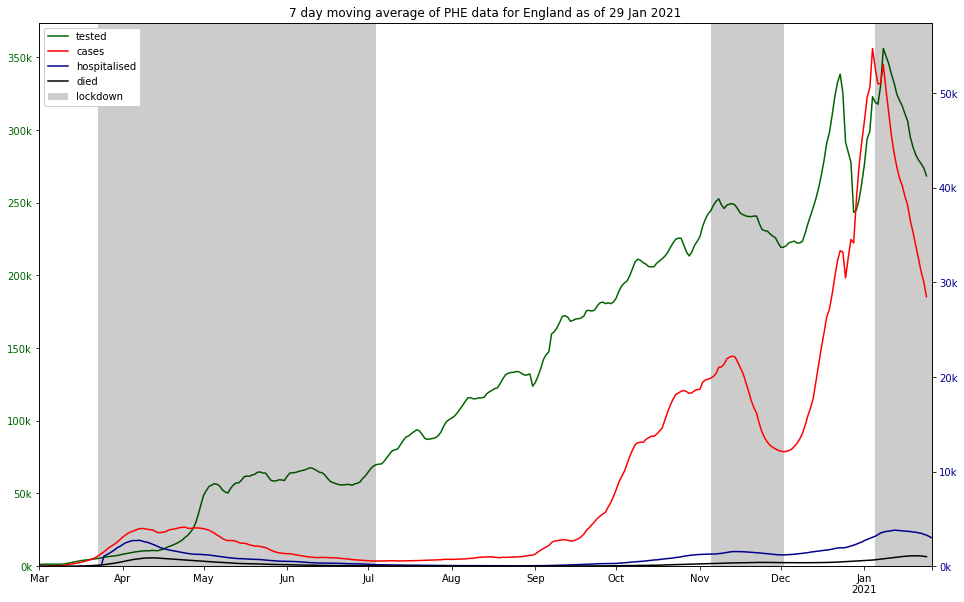

In [19]:
plot_summary(earliest_date='2020-03-01', tested_formatter=lambda y, pos: f"{y / 1_000:,.0f}k")

In [20]:
download('vaccination', 'nation', *vaccination_new_and_weekly, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_2021-01-29.csv')

In [21]:
download('vaccination_cum', 'nation', *vaccination_cumulative, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_cum_2021-01-29.csv')

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,Northern Ireland,N92000002,24070.0,196131.0,172061.0,1893667,1.271079,9.086128,89.642794
1,Scotland,S92000003,7095.0,515855.0,508760.0,5463300,0.129867,9.312320,90.557813
2,Wales,W92000004,717.0,362253.0,361536.0,3152879,0.022741,11.466853,88.510406
3,England,E92000001,446372.0,6816945.0,6370573.0,56286961,0.793029,11.318026,87.888945


'7,891,184'

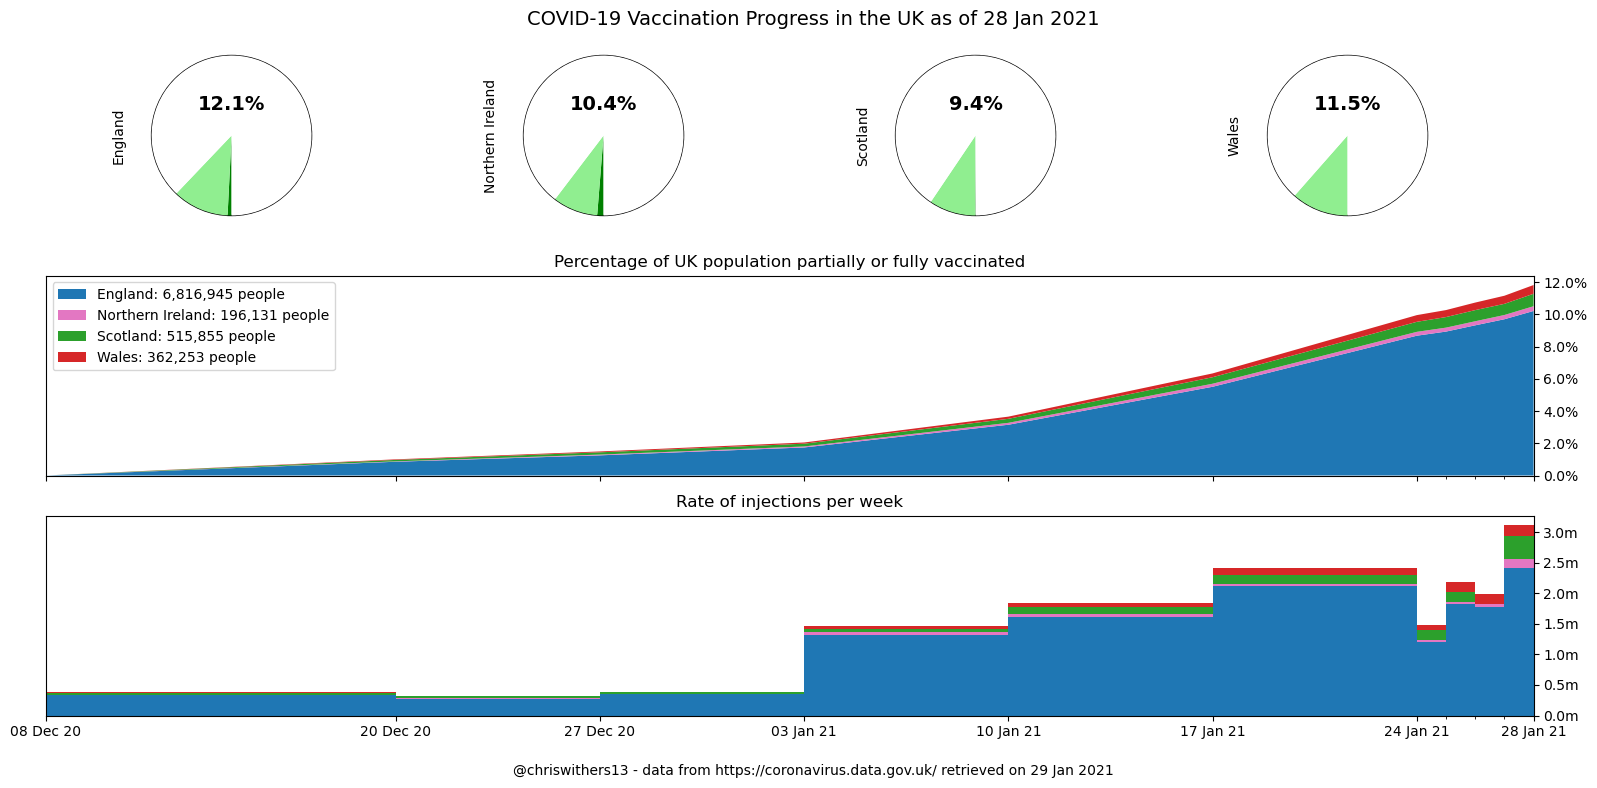

In [22]:
results = vaccination_dashboard()
display(results)
f"{results['any'].sum():,.0f}"

In [23]:
vaccination_corrections()

In [24]:
download(nation, nation, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/nation_2021-01-29.csv')

In [25]:
download(region, region, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/region_2021-01-29.csv')

In [26]:
download(ltla, ltla, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/ltla_2021-01-29.csv')

In [27]:
if is_msoa_data_ready():
    path = download(msoa, msoa, new_cases_sum, new_cases_rate, new_cases_change, 'release', release=release)
    display(path)
    check_path(path)

today: 2021-01-29, release: 2021-01-29 16:00:12.330459+00:00, msoa: 2021-01-29 16:40:40+00:00


PosixPath('/Users/chris/coronavirus/data/msoa_2021-01-29.csv')